<a href="https://colab.research.google.com/github/conjure-cp/conjure/blob/main/docs/tutorials/notebooks/NurseRostering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nurse Rostering

Original [Nurse Rostering](https://conjure.readthedocs.io/en/latest/tutorials/NurseRostering.html) by András Salamon, Nguyen Dang and Saad Attieh. Adapted by Alex Gallagher.

We now discuss a version of [Nurse Rostering](https://en.wikipedia.org/wiki/Nurse_scheduling_problem), a constrained scheduling problem. Variants of this problem are also known by other names, such as workforce planning and staff scheduling. Unlike versions of this problem studied by operations research practitioners and researchers (such as competition instances [CDDC+19](https://conjure.readthedocs.io/en/latest/zreferences.html#id4), we here focus on just a few of the simplest constraints.

Some nurses are available to work in a hospital. Each day is divided into a sequence of shifts, for instance an early-morning shift, a day shift, and a night shift. Each nurse should be assigned to work some shifts during the course of a period of consecutive days. A nurse can be assigned to at most one shift per day. Moreover, for each nurse we need to avoid some forbidden shift patterns within two consecutive days. For example, a nurse cannot work a night shift on one day, and an early-morning shift the next day. We also must make sure to meet the minimum number of nurses required for each shift. These demand values may vary between different days.

In [10]:
!source <(curl -s https://raw.githubusercontent.com/conjure-cp/conjure-notebook/v0.0.9/scripts/install-colab.sh)
%load_ext conjure

Installing Conjure version v2.5.1 and Conjure Notebook version v0.0.9...
Conjure is already installed.
Conjure notebook is already installed.
Conjure: The Automated Constraint Modelling Tool
Release version 2.5.1
Repository version a9cbc2e (2023-11-07 23:44:00 +0000)
The conjure extension is already loaded. To reload it, use:
  %reload_ext conjure


In [11]:
%conjure_settings

## Initial specification

To begin with, let’s ignore the forbidden patterns, and focus instead on the elements needed to model the problem. We need nurses, shifts for each day, the minimum demand, and a roster.

`given nNurses, nDays : int(1..)`

`given shifts new type enum`

`letting days be domain int(1..nDays)`

`letting nurses be domain int(1..nNurses)`

`letting nShifts be |'shifts'|`

`given forbiddenPatterns : set of tuple (shifts, shifts)`

`given minimumDemand : function (total) (days, shifts) --> int(0..nNurses)`

`where`

   `forAll d : days .`

  `(sum s : shifts . minimumDemand((d,s))) <= nNurses`

`find roster: function (days, shifts) --> nurses`

`$ constraint 1 (Single assignment per day)`

`$ a nurse can be assigned to at most one shift per day`

`such that`

`forAll nurse : nurses .`

`forAll day : days .`

`(sum ((d,_),n) in roster . toInt(n=nurse /\ d=day)) <= 1`

This specification contains the basic elements. We made the choice to use an enumerated type for shifts, positive integers to number the nurses and the days, a set of forbidden patterns (each being a pair of shifts), and a total function mapping each shift slot to a number of nurses to represent the minimum demands. Because we only allow a nurse to work one shift each day, the forbidden patterns can only apply to one day and the next day, with the first shift in a forbidden pattern referring to the first day and the second shift referring to the subsequent day. We also added a `where` condition to ensure that instances are not trivially impossible, by requiring the minimum demand to never exceed the number of nurses.

We also need a test instance. Generating test instances is an interesting subject (for instance, see [AkgunDM+19](https://conjure.readthedocs.io/en/latest/zreferences.html#id5)) but here we have just made one up.

In [12]:
%%conjure
letting nNurses be 5
letting nDays be 7
letting shifts be new type enum {Early, Late, Night}
letting forbiddenPatterns be {
   (Late,Early), (Night,Early), (Night,Late)
}
letting minimumDemand be function (
   (1,Early) --> 2, (1,Late) --> 2, (1,Night) --> 0,
   (2,Early) --> 1, (2,Late) --> 1, (2,Night) --> 2,
   (3,Early) --> 1, (3,Late) --> 1, (3,Night) --> 1,
   (4,Early) --> 0, (4,Late) --> 0, (4,Night) --> 1,
   (5,Early) --> 1, (5,Late) --> 1, (5,Night) --> 2,
   (6,Early) --> 2, (6,Late) --> 1, (6,Night) --> 1,
   (7,Early) --> 0, (7,Late) --> 1, (7,Night) --> 1
)
letting days be domain int(1..nDays)
letting nurses be domain int(1..nNurses)
letting nShifts be |`shifts`|

```json
{}
```

| Statistic | Value |
|:-|-:|
| SolverTotalTime | 0.000 |
| SavileRowClauseOut | 0 |
| SavileRowTotalTime | 0.058 |
| SolverFailures | 0 |
| SolverSatisfiable | 1 |
| SavileRowTimeOut | 0 |
| SolverTimeOut | 0 |
| SolverNodes | 1 |


We have 5 nurses, 7 days in the period, three shifts each day, three forbidden pairs of shifts, and some minimum demands for the various shifts.

## Final model

This is a specification that captures the key constraints we wanted to include.

As this model can take a while to run, much faster way to obtain a solution is to ask Minion [CDDC+19](https://conjure.readthedocs.io/en/latest/zreferences.html#id4to) use the domoverwdeg variable ordering, which is often effective on constrained scheduling problems:

In [13]:
%%conjure+ --solver=minion --solver-options='-varorder domoverwdeg'
find roster: function (days, nurses) --> shifts
$ constraint 1 (Single assignment per day)
$ a nurse can be assigned to at most one shift per day
$ NOTE: automatically satisfied because of how "roster" is defined

$ constraint 2 (Under staffing)
$ the number of nurses for each shift suffice for the minimum demand
such that
   forAll day : days .
      forAll shift : shifts .
         (sum ((d,_),s) in roster . toInt(d=day /\ s=shift))
            >= minimumDemand((day,shift))

$ constraint 3 (Shift type successions)
$ the shift type assignments of one nurse on two consecutive days
$ must not violate any forbidden succession
such that
   forAll d : int(1..(nDays-1)) .
      forAll n : nurses .
         !((roster((d,n)), roster((d+1,n))) in forbiddenPatterns)

```json
{"roster": [[[1, 2], "Early"], [[1, 3], "Early"], [[1, 4], "Late"], [[1, 5], "Late"], [[2, 2], "Early"], [[2, 3], "Late"], [[2, 4], "Night"], [[2, 5], "Night"], [[3, 2], "Early"], [[3, 3], "Late"], [[3, 4], "Night"], [[4, 5], "Night"], [[5, 2], "Early"], [[5, 3], "Late"], [[5, 4], "Night"], [[5, 5], "Night"], [[6, 1], "Early"], [[6, 2], "Early"], [[6, 3], "Late"], [[6, 4], "Night"], [[7, 4], "Night"], [[7, 5], "Late"]]}
```

| Statistic | Value |
|:-|-:|
| SolverTotalTime | 0.069891 |
| SavileRowClauseOut | 0 |
| SolverSolveTime | 0.065135 |
| SavileRowTotalTime | 0.783 |
| SolverSatisfiable | 1 |
| SavileRowTimeOut | 0 |
| SolverNodes | 40 |
| SolverTimeOut | 0 |
| SolverSolutionsFound | 1 |
| SolverSetupTime | 0.001835 |


Choosing the right parameters to control solver behaviour is important but not generally well understood, and we leave discussion of this problem for another time.

## Visualisations

We can display the nurse roster using graphs:

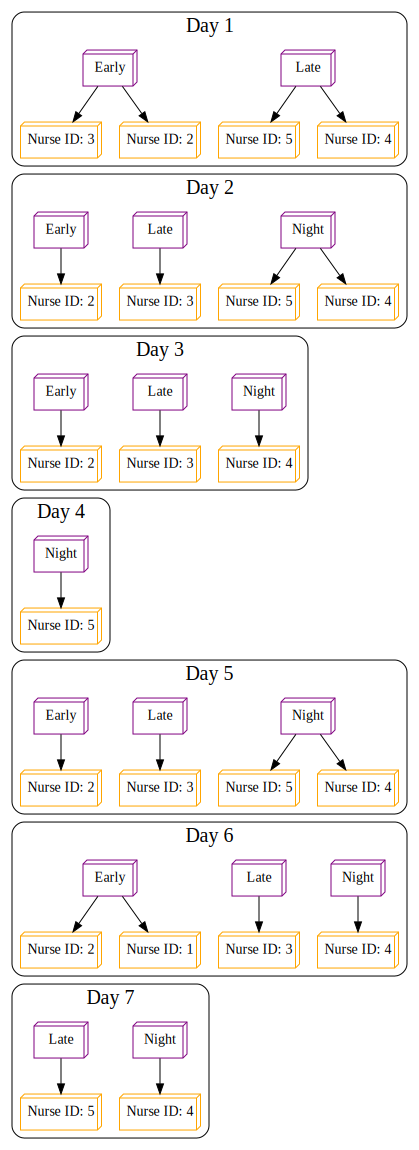

In [14]:
import graphviz

p = graphviz.Digraph('parent')
p.attr(compound='true')

nDays = 7;
edges = []
id = 0

roster = sorted(roster, key=lambda item: item[1])
roster.reverse()

for day in range (1, nDays+1):
    with p.subgraph(name='cluster'+str(day), node_attr={'shape': 'box3d', 'color': 'purple', 'style':'rounded'}) as c:
      for item in roster:
        # if it is the selected day
        if item[0][0] == day:
          # add the time of day if it doesn't exist already
          c.node(str(item[1])+str(day), item[1])
          # print(str(item[1])+str(day))
          # add the nurse
          c.node(str(id), "Nurse ID: " + str(item[0][1]), color='orange')
          # print(str(id), "nurse: ", str(item[0][1]))
          # add the edge
          edges.append([str(item[1])+str(day), str(id)])
          id=id+1
      c.attr(label="Day "+str(day))
      c.attr(style='rounded')
      c.attr(fontsize='20')

# force each subgraph to be on new line
p.edge('2', 'Early2', None, {'style':'invis'})
p.edge('7', 'Early3', None, {'style':'invis'})
p.edge('10', 'Night4', None, {'style':'invis'})
p.edge('11', 'Early5', None, {'style':'invis'})
p.edge('12', 'Late6', None, {'style':'invis'})
p.edge('18', 'Late7', None, {'style':'invis'})

p.edges(edges)

p

We can also display the roster as the timetable for each nurse:

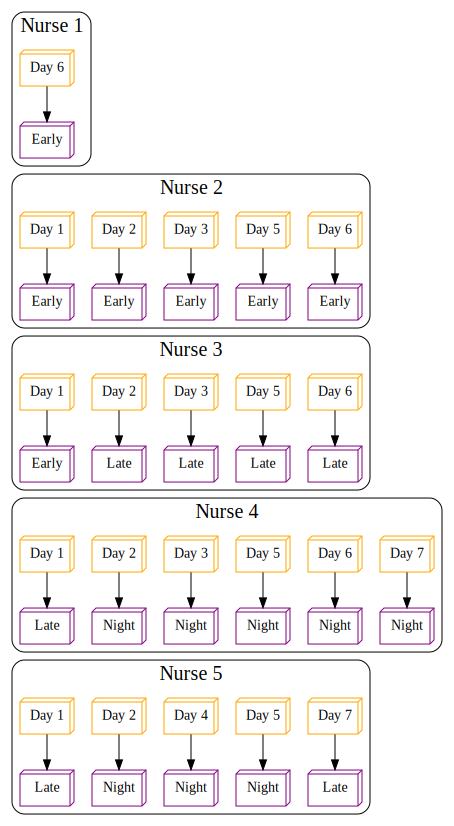

In [15]:
p = graphviz.Digraph('parent')
p.attr(compound='true')
p.attr(rankdir="TB")

nNurses = 5;
edges = []
id = 0

roster = sorted(roster, key=lambda item: item[0][0])
roster.reverse()

for nurse in range (1, nNurses+1):
    with p.subgraph(name='cluster'+str(nurse), node_attr={'shape': 'box3d', 'color': 'purple', 'style':'rounded'}) as c:

      for item in roster:
        # if it is the selected nurse
        if item[0][1] == nurse:

          # add the day
          c.node(str(id), "Day " + str(item[0][0]), color='orange')

          # add the time of day
          c.node((str(id) + str(item[1]))+str(nurse), item[1])

          # add the edge
          edges.append([str(id), (str(id) + str(item[1]))+str(nurse)])
          id=id+1
      c.attr(label="Nurse "+str(nurse))
      c.attr(style='rounded')
      c.attr(fontsize='20')



# force each subgraph to be on new line
p.edge('0Early1', '5', None, {'style':'invis'})
p.edge('5Early2', '10', None, {'style':'invis'})
p.edge('10Early3', '16', None, {'style':'invis'})
p.edge('16Late4', '21', None, {'style':'invis'})

p.edges(edges)

p

## Running without domoverwdeg variable

If you are interested in how long the model takes to find the solution without using the ```domoverwdeg``` variable, run the cell below.

In [16]:
%%conjure+ --solver=minion


```json
{"roster": [[[1, 2], "Early"], [[1, 3], "Early"], [[1, 4], "Late"], [[1, 5], "Late"], [[2, 2], "Night"], [[2, 3], "Early"], [[2, 4], "Late"], [[2, 5], "Night"], [[3, 3], "Early"], [[3, 4], "Late"], [[3, 5], "Night"], [[4, 5], "Night"], [[5, 2], "Night"], [[5, 3], "Early"], [[5, 4], "Late"], [[5, 5], "Night"], [[6, 1], "Early"], [[6, 3], "Early"], [[6, 4], "Late"], [[6, 5], "Night"], [[7, 4], "Late"], [[7, 5], "Night"]]}
```

| Statistic | Value |
|:-|-:|
| SolverTotalTime | 4127.67 |
| SavileRowClauseOut | 0 |
| SolverSolveTime | 4127.67 |
| SavileRowTotalTime | 1.17 |
| SolverSatisfiable | 1 |
| SavileRowTimeOut | 0 |
| SolverNodes | 1017403545 |
| SolverTimeOut | 0 |
| SolverSolutionsFound | 1 |
| SolverSetupTime | 0.001693 |
